In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
import os




In [37]:
def load_and_process_csv(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df = df.replace('-', 0)
    columns_to_remove = ['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name']
    existing_columns = [col for col in columns_to_remove if col in df.columns]
    if existing_columns:
        df = df.drop(columns=existing_columns)
    if 'district_id' in df.columns:
        for col in df.columns:
            if col != 'district_id':
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
        if 'district_id' in numeric_columns:
            numeric_columns.remove('district_id')
        df_grouped = df.groupby('district_id')[numeric_columns].sum().reset_index()
        return df_grouped
    else:
        return df

def merge_all_census_data(data_dir: str = "Data") -> pd.DataFrame:
    h27_files = []
    for file in os.listdir(data_dir):
        if file.startswith('h27_') and file.endswith('.csv'):
            h27_files.append(os.path.join(data_dir, file))
    
    dataframes = {}
    for file_path in h27_files:
        file_name = os.path.basename(file_path).replace('.csv', '')
        df = load_and_process_csv(file_path)
        dataframes[file_name] = df
    
    income_file = os.path.join(data_dir, "income_district.csv")
    if os.path.exists(income_file):
        income_df = pd.read_csv(income_file)
        merged_df = income_df.copy()
    else:
        first_file = list(dataframes.keys())[0]
        merged_df = dataframes[first_file].copy()
    
    # 逐个合并其他数据
    for file_name, df in dataframes.items():
        if file_name == 'income_district':
            continue
            
        if 'district_id' in df.columns and 'area_code' in merged_df.columns:
            merged_df = merged_df.merge(df, left_on='area_code', right_on='district_id', how='left')
            if 'district_id' in merged_df.columns:
                merged_df = merged_df.drop(columns=['district_id'])
        elif 'district_id' in df.columns and 'district_id' in merged_df.columns:
            merged_df = merged_df.merge(df, on='district_id', how='left')
        else:
            continue
    
    numeric_columns = merged_df.select_dtypes(include=[np.number]).columns
    merged_df[numeric_columns] = merged_df[numeric_columns].fillna(0)
    
    return merged_df

In [38]:

merged_data = merge_all_census_data()
print(merged_data.head())
merged_data.to_csv('merged_census_data.csv', index=False)


   area_code  income_mean  population  male_population  female_population  \
0      13228   480.984419    187633.0          93213.0            94420.0   
1      43514   439.775281     31046.0          14356.0            16690.0   
2      23237   487.507769    200940.0         100032.0           100908.0   
3      18208   505.495103     74313.0          35014.0            39299.0   
4      12238   385.423846     77188.0          37438.0            39750.0   

   family_count_x  employer_male  self_employed_male  family_work_male  \
0         71490.0        37511.0              5706.0             426.0   
1         10596.0         5426.0              1980.0             510.0   
2         76955.0        46994.0              6357.0             480.0   
3         25494.0        17224.0              2915.0             338.0   
4         29698.0        14714.0              3576.0             488.0   

   unkonwn_status_male  ...  K_real_estate_female  L_academic_female  \
0               2876

In [39]:

features_df = merged_data.copy()


if 'population' in features_df.columns:
    features_df['population_density'] = features_df['population'] / 1000
    if 'male_population' in features_df.columns and 'female_population' in features_df.columns:
        features_df['male_ratio'] = features_df['male_population'] / features_df['population']
        features_df['female_ratio'] = features_df['female_population'] / features_df['population']

age_columns = [col for col in features_df.columns if any(age in col for age in ['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64'])]
elderly_columns = [col for col in features_df.columns if any(age in col for age in ['65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100'])]

if age_columns and 'population' in features_df.columns:
    features_df['working_age_ratio'] = features_df[age_columns].sum(axis=1) / features_df['population']
if elderly_columns and 'population' in features_df.columns:
    features_df['elderly_ratio'] = features_df[elderly_columns].sum(axis=1) / features_df['population']

if 'labor_male' in features_df.columns and 'labor_female' in features_df.columns:
    features_df['total_labor'] = features_df['labor_male'] + features_df['labor_female']
    features_df['labor_ratio'] = features_df['total_labor'] / features_df['population']

professional_cols = [col for col in features_df.columns if 'professional' in col.lower()]
service_cols = [col for col in features_df.columns if 'service' in col.lower()]
office_cols = [col for col in features_df.columns if 'office' in col.lower()]

if professional_cols:
    features_df['professional_ratio'] = features_df[professional_cols].sum(axis=1) / features_df['total_labor']
if service_cols:
    features_df['service_ratio'] = features_df[service_cols].sum(axis=1) / features_df['total_labor']
if office_cols:
    features_df['office_ratio'] = features_df[office_cols].sum(axis=1) / features_df['total_labor']

manufacturing_cols = [col for col in features_df.columns if 'manufacturing' in col.lower()]
finance_cols = [col for col in features_df.columns if 'finance' in col.lower()]
education_cols = [col for col in features_df.columns if 'education' in col.lower()]

if manufacturing_cols:
    features_df['manufacturing_ratio'] = features_df[manufacturing_cols].sum(axis=1) / features_df['total_labor']
if finance_cols:
    features_df['finance_ratio'] = features_df[finance_cols].sum(axis=1) / features_df['total_labor']
if education_cols:
    features_df['education_ratio'] = features_df[education_cols].sum(axis=1) / features_df['total_labor']

if 'family_house' in features_df.columns and 'family_count' in features_df.columns:
    features_df['avg_family_size'] = features_df['family_member_count'] / features_df['family_count']

if 'own_house_family' in features_df.columns and 'family_house' in features_df.columns:
    features_df['own_house_ratio'] = features_df['own_house_family'] / features_df['family_house']

if 'married' in features_df.columns and 'unmarried' in features_df.columns:
    features_df['marriage_ratio'] = features_df['married'] / (features_df['married'] + features_df['unmarried'])

if 'employer_male' in features_df.columns and 'employer_female' in features_df.columns:
    features_df['employer_ratio'] = (features_df['employer_male'] + features_df['employer_female']) / features_df['total_labor']



new_features = [col for col in features_df.columns if col not in merged_data.columns]
features_df = features_df[new_features + ['area_code', 'income_mean']]
print(f"Total features numbers: {len(features_df.columns)}")

Total features numbers: 18


In [40]:


exclude_cols = ['area_code', 'income_mean']
feature_cols = [col for col in features_df.columns if col not in exclude_cols]

features_df = features_df.replace([np.inf, -np.inf], np.nan)
features_df = features_df.fillna(0)

X = features_df[feature_cols]
y = features_df['income_mean']

print(f"feature numbers: {len(feature_cols)}")
print(f"sample numbers: {len(X)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"train set size: {X_train.shape}")
print(f"test set size: {X_test.shape}")

print("\n income statistics:")
print(y.describe())

feature numbers: 16
sample numbers: 1245
train set size: (996, 16)
test set size: (249, 16)

 income statistics:
count    1245.000000
mean      450.894044
std        63.392037
min       256.927711
25%       409.714645
50%       453.735961
75%       490.880000
max       720.728720
Name: income_mean, dtype: float64


In [41]:

models = {
    'LR': LinearRegression(),
    'RF': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}

for name, model in models.items():
    if name == 'LR':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    if name == 'LR':
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'CV_R2_mean': cv_scores.mean(),
        'CV_R2_std': cv_scores.std(),
        'y_pred': y_pred,
        'model': model
    }
    
    print(f"  R2: {r2:.4f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  CV R2: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\nmodel training completed!")

  R2: 0.7754
  RMSE: 30.21
  MAE: 23.62
  CV R2: 0.7600 (+/- 0.0541)
  R2: 0.7823
  RMSE: 29.74
  MAE: 22.54
  CV R2: 0.7423 (+/- 0.0615)

model training completed!


In [42]:

rf_model = results['RF']['model']
importance = rf_model.feature_importances_

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
}).sort_values('importance', ascending=False)

print(feature_importance.head(5))

               feature  importance
8        service_ratio    0.206696
15      employer_ratio    0.182576
4        elderly_ratio    0.085995
7   professional_ratio    0.080119
2         female_ratio    0.070304


In [43]:

performance_df = pd.DataFrame({
    'model': list(results.keys()),
    'R2': [results[name]['R2'] for name in results.keys()],
    'RMSE': [results[name]['RMSE'] for name in results.keys()],
    'MAE': [results[name]['MAE'] for name in results.keys()],
    'CV R2': [results[name]['CV_R2_mean'] for name in results.keys()],
    'CV R2 std': [results[name]['CV_R2_std'] for name in results.keys()]
})

print(performance_df.round(4))

best_model_name = max(results.keys(), key=lambda x: results[x]['R2'])
best_result = results[best_model_name]

print(f"\nbest model: {best_model_name}")
print(f"- R2: {best_result['R2']:.4f}")
print(f"- RMSE: {best_result['RMSE']:.2f}")
print(f"- MAE: {best_result['MAE']:.2f}")
print(f"- CV R2: {best_result['CV_R2_mean']:.4f} (+/- {best_result['CV_R2_std']*2:.4f})")

  model      R2     RMSE      MAE   CV R2  CV R2 std
0    LR  0.7754  30.2105  23.6168  0.7600     0.0271
1    RF  0.7823  29.7372  22.5373  0.7423     0.0307

best model: RF
- R2: 0.7823
- RMSE: 29.74
- MAE: 22.54
- CV R2: 0.7423 (+/- 0.0615)


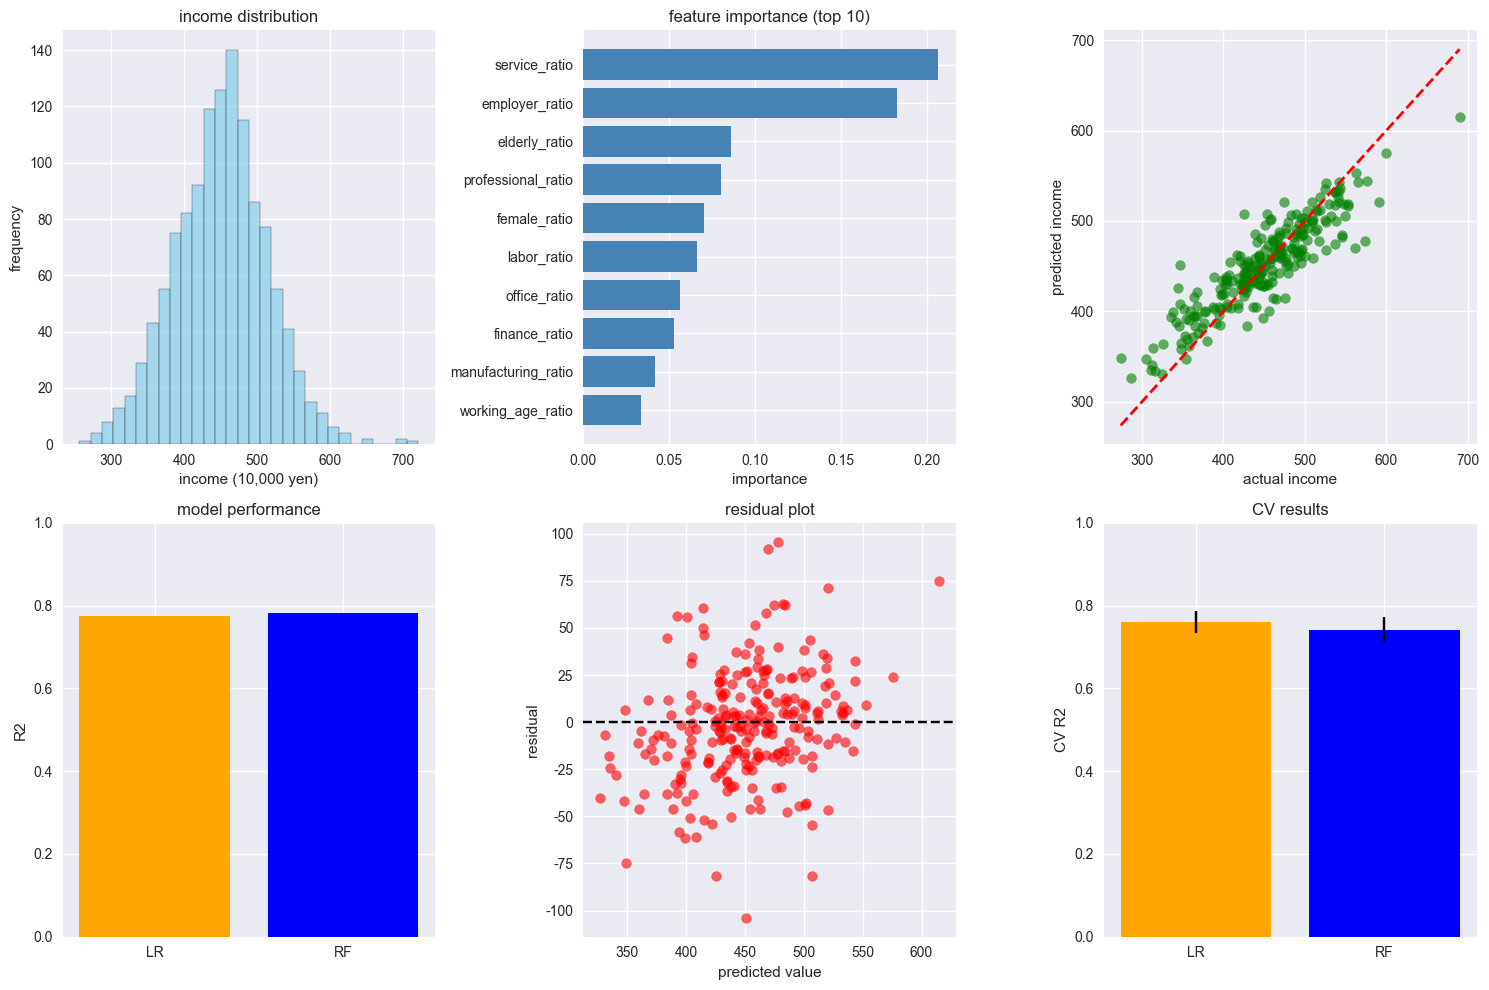

In [44]:

plt.style.use('seaborn-v0_8')
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(y, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('income distribution')
plt.xlabel('income (10,000 yen)')
plt.ylabel('frequency')


plt.subplot(2, 3, 2)
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('importance')
plt.title('feature importance (top 10)')
plt.gca().invert_yaxis()

plt.subplot(2, 3, 3)
y_pred = results[best_model_name]['y_pred']
plt.scatter(y_test, y_pred, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('actual income')
plt.ylabel('predicted income')


plt.subplot(2, 3, 4)
model_names = list(results.keys())
r2_scores = [results[name]['R2'] for name in model_names]
plt.bar(model_names, r2_scores, color=['orange', 'blue'])
plt.ylabel('R2')
plt.title('model performance')
plt.ylim(0, 1)

plt.subplot(2, 3, 5)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('predicted value')
plt.ylabel('residual')
plt.title('residual plot')

plt.subplot(2, 3, 6)
cv_means = [results[name]['CV_R2_mean'] for name in model_names]
cv_stds = [results[name]['CV_R2_std'] for name in model_names]
plt.bar(model_names, cv_means, yerr=cv_stds, capsize=5, color=['orange', 'blue'])
plt.ylabel('CV R2')
plt.title('CV results')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('income_prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()


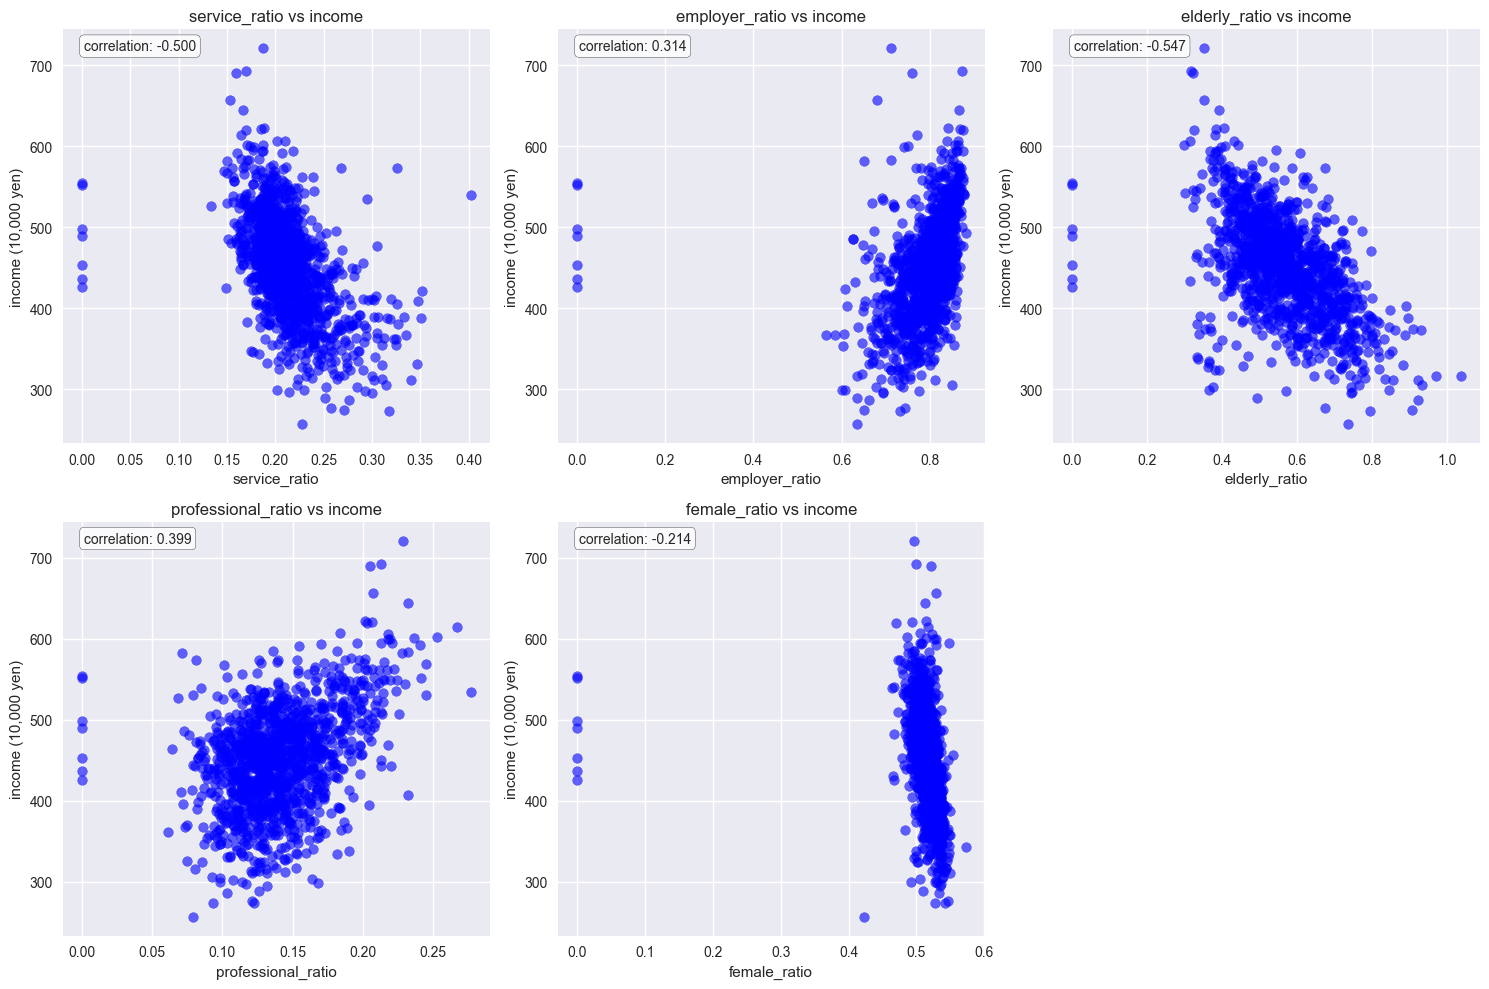


correlation between features and income:
service_ratio            : -0.5002
employer_ratio           : 0.3143
elderly_ratio            : -0.5469
professional_ratio       : 0.3988
female_ratio             : -0.2141


In [45]:


top_5_features = feature_importance.head(5)['feature'].tolist()

plt.figure(figsize=(15, 10))

for i, feature in enumerate(top_5_features, 1):
    plt.subplot(2, 3, i)
    plt.scatter(features_df[feature], features_df['income_mean'], alpha=0.6, color='blue')
    plt.xlabel(feature)
    plt.ylabel('income (10,000 yen)')
    plt.title(f'{feature} vs income')
    
    corr = features_df[feature].corr(features_df['income_mean'])
    plt.text(0.05, 0.95, f'correlation: {corr:.3f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\ncorrelation between features and income:")
for feature in top_5_features:
    corr = features_df[feature].corr(features_df['income_mean'])
    print(f"{feature:<25}: {corr:.4f}")